## 使用LSTM生成正弦波

### 1. 训练集，验证集和测试集的生成

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
np.random.seed(2)

T = 20
L = 1000
N = 100

x = np.empty((N, L), 'int64')
x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
data = np.sin(x / 1.0 / T).astype('float64')

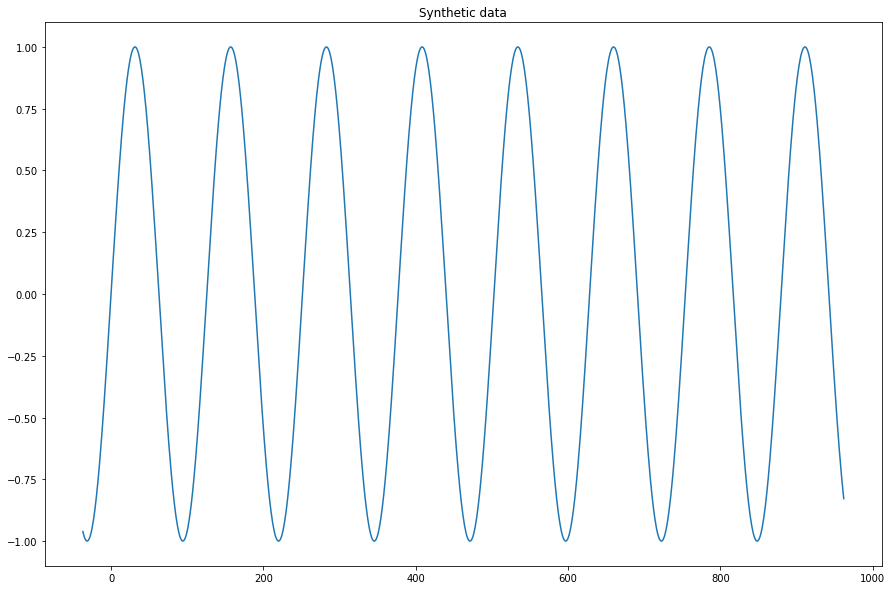

In [3]:
# 其中一个正弦波

plt.figure("Synthetic data", figsize=(15, 10))
plt.title("Synthetic data")
plt.plot(x[3], data[3])
plt.show()
plt.close()

### 2. 定义LSTM

In [4]:
# 注意！ LSTM内部的hidden states和cell states都要转移到GPU上！
# 但这里使用GPU好像更慢 ？？

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class lstm(nn.Module):
    def __init__(self, input_size=1, hidden_size=20, output_size=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # 使用两层LSTMCell堆积来提高模型表达力
        self.layer1 = nn.LSTMCell(input_size=self.input_size, hidden_size=self.hidden_size)
        self.layer2 = nn.LSTMCell(input_size=self.hidden_size, hidden_size=self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, input_data, future=0):
        outputs = []
        
        # LSTM cell的三个输入：input(batch,input_size), h_0(batch,hidden_size), c_0(batch,hidden_size)
        
        # init hidden states and cell state for layer1
        h_t = torch.zeros(input_data.size(0), self.hidden_size, dtype=torch.double).to(device)
        c_t = torch.zeros(input_data.size(0), self.hidden_size, dtype=torch.double).to(device)
        
        # init hidden states and cell state for layer2
        h_t2 = torch.zeros(input_data.size(0), self.hidden_size, dtype=torch.double).to(device)
        c_t2 = torch.zeros(input_data.size(0), self.hidden_size, dtype=torch.double).to(device)
        
        # input_data:[97, 999], chunk将tensor按第二个维度分成999块
        # 97个样本，seq_len为999
        for i, input_t in enumerate(input_data.chunk(input_data.size(1), dim=1)):
            # 每个input_t是 97x1 的tensor， batch=97，input_size=1
            h_t, c_t = self.layer1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.layer2(h_t, (h_t2, c_t2))
            # output的大小为 97x1
            output = self.linear(h_t2)
            outputs += [output]
            
        for i in range(future):# if we should predict the future
            h_t, c_t = self.layer1(output, (h_t, c_t))
            h_t2, c_t2 = self.layer2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]

        outputs = torch.stack(outputs, 1).squeeze(2)
        
        return outputs

### 3. 训练

In [6]:
# set random seed to 0

np.random.seed(0)
torch.manual_seed(0)

In [7]:
# build the network

lstm = lstm().double().to(device)
criterion = nn.MSELoss()

# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.LBFGS(lstm.parameters(), lr=0.8)

In [8]:
# load data and make training set

train_input = torch.from_numpy(data[3:, :-1]).to(device)  # 排除最后一个
train_target = torch.from_numpy(data[3:, 1:]).to(device)  # 排除第一个
test_input = torch.from_numpy(data[:3, :-1]).to(device)
test_target = torch.from_numpy(data[:3, 1:]).to(device)

In [9]:
 #begin to train
    
for i in range(15):
    print('STEP: ', i)
    
    def closure():
        optimizer.zero_grad()
        out = lstm(train_input)
        loss = criterion(out, train_target)
        print('loss:', loss.item())
        loss.backward()
        return loss
    
    optimizer.step(closure)

STEP:  0
loss: 0.5742112261057678
loss: 0.5347613204293521
loss: 0.4886682958613091
loss: 0.4765957929096425
loss: 0.4446690276191447
loss: 0.2227167857821135
loss: 0.9692247269537281
loss: 0.10646219807160803
loss: 0.05388275649942032
loss: 0.040346639794730854
loss: 0.03827205508954104
loss: 0.036087346839151185
loss: 0.03175143413983134
loss: 0.025683458511245903
loss: 0.01904541427557726
loss: 0.015023735161977197
loss: 0.01334486740412893
loss: 0.011578695026158168
loss: 0.007501459023114749
loss: 0.003202995187840242
STEP:  1
loss: 0.0020772546985317855
loss: 0.001388539510872874
loss: 0.0013282727373967423
loss: 0.0012749645093575908
loss: 0.001170641236256353
loss: 0.0010342853377113736
loss: 0.0009197618175678129
loss: 0.000877092165526209
loss: 0.0008628628267110241
loss: 0.0008442413320300556
loss: 0.0008158671646393491
loss: 0.000769360362942957
loss: 0.0007004252591071262
loss: 0.000595830747354486
loss: 0.0004960821559479068
loss: 0.00041437077020807327
loss: 0.0003921298

In [11]:
# begin to predict, no need to track gradient here

with torch.no_grad():
    future = 1000
    pred = lstm(test_input, future=future)
    loss = criterion(pred[:, :-future], test_target)
    print('test loss:', loss.item())
    y = pred.detach().cpu().numpy()

test loss: 6.966327321877437e-06


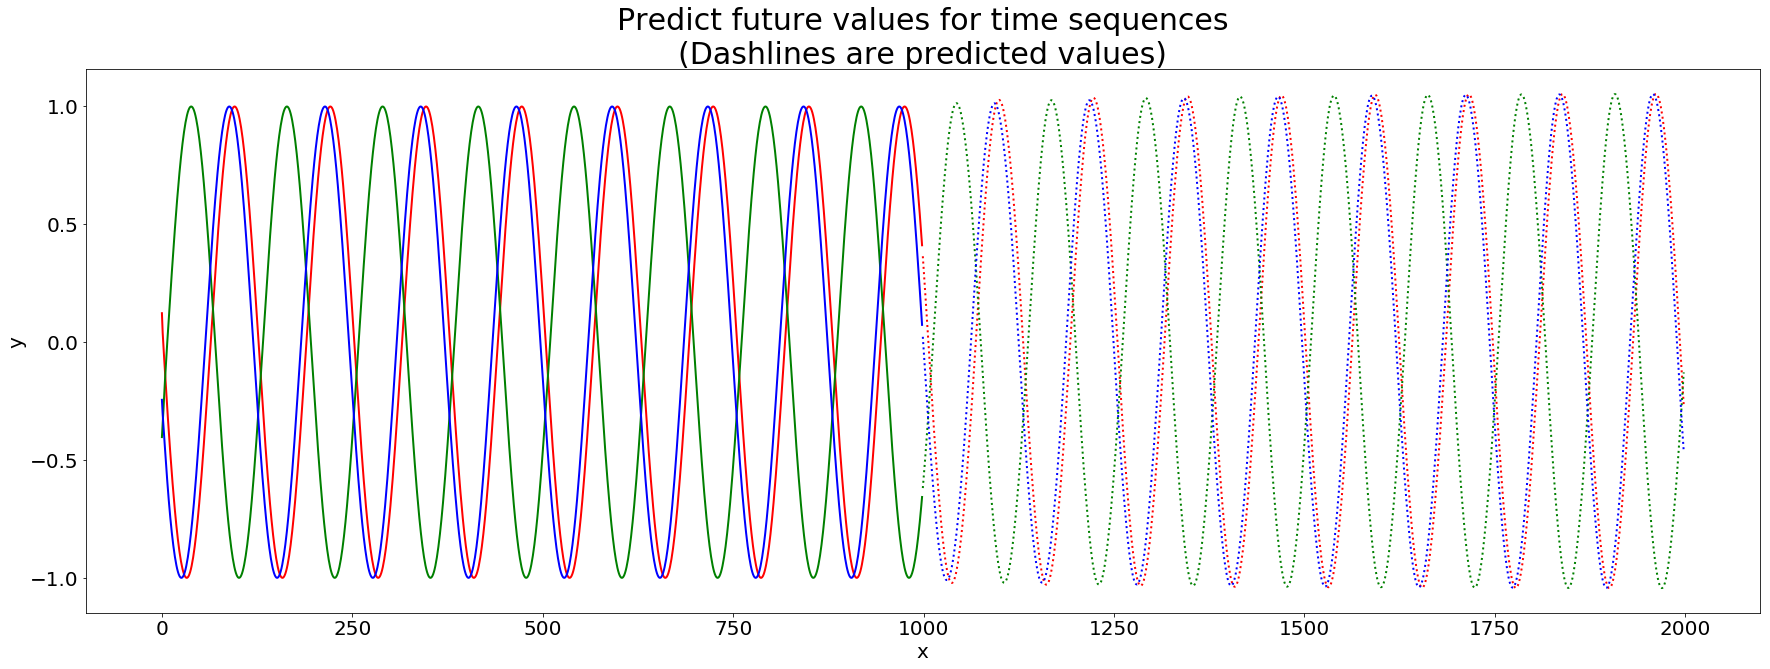

In [12]:
# draw the result
plt.figure(figsize=(30,10))
plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

def draw(yi, color):
    plt.plot(np.arange(train_input.size(1)), yi[:train_input.size(1)], color, linewidth = 2.0)
    plt.plot(np.arange(train_input.size(1), train_input.size(1) + future), yi[train_input.size(1):], color + ':', linewidth = 2.0)
    
draw(y[0], 'r')
draw(y[1], 'g')
draw(y[2], 'b')

plt.show()
plt.close()